# notMNIST Character Recognition using Tensorflow

In this small project, we develope a simple neural network to detect characters in [nonMNIST](http://yaroslavvb.blogspot.ca/2011/09/notmnist-dataset.html) dataset using *Tensorflow*. 

The original example has been presented by [Udacity](https://www.udacity.com/).

**Input:**
- A set of nonMNIST character images from letter A to J

**Goal:**
- Prediction of a sample nonMNIST image

In [1]:
# Import required modules
import hashlib
import os
import pickle
from urllib.request import urlretrieve

import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import resample
from tqdm import tqdm
from zipfile import ZipFile

print('All modules imported.')

All modules imported.


## Download and uncompressed the nonMNIST dataset

In [2]:
def download(url, file):
    """
    Download file from <url>
    :param url: URL to file
    :param file: Local file path
    """
    if not os.path.isfile(file):
        print('Downloading ' + file + '...')
        urlretrieve(url, file)
        print('Download Finished')

# Download the training and test dataset.
download('https://s3.amazonaws.com/udacity-sdc/notMNIST_train.zip', './data/notMNIST_train.zip')
download('https://s3.amazonaws.com/udacity-sdc/notMNIST_test.zip', './data/notMNIST_test.zip')

# Make sure the files aren't corrupted
assert hashlib.md5(open('./data/notMNIST_train.zip', 'rb').read()).hexdigest() == 'c8673b3f28f489e9cdf3a3d74e2ac8fa',\
        'notMNIST_train.zip file is corrupted.  Remove the file and try again.'
assert hashlib.md5(open('./data/notMNIST_test.zip', 'rb').read()).hexdigest() == '5d3c7e653e63471c88df796156a9dfa9',\
        'notMNIST_test.zip file is corrupted.  Remove the file and try again.'

# Wait until you see that all files have been downloaded.
print('All files downloaded.')

All files downloaded.


In [3]:
def uncompress_features_labels(file):
    """
    Uncompress features and labels from a zip file
    :param file: The zip file to extract the data from
    """
    features = []
    labels = []

    with ZipFile(file) as zipf:
        # Progress Bar
        filenames_pbar = tqdm(zipf.namelist(), unit='files')
        
        # Get features and labels from all files
        for filename in filenames_pbar:
            # Check if the file is a directory
            if not filename.endswith('/'):
                with zipf.open(filename) as image_file:
                    image = Image.open(image_file)
                    image.load()
                    # Load image data as 1 dimensional array
                    # We're using float32 to save on memory space
                    feature = np.array(image, dtype=np.float32).flatten()

                # Get the the letter from the filename.  This is the letter of the image.
                label = os.path.split(filename)[1][0]

                features.append(feature)
                labels.append(label)
    return np.array(features), np.array(labels)

# Get the features and labels from the zip files
train_features, train_labels = uncompress_features_labels('./data/notMNIST_train.zip')
test_features, test_labels = uncompress_features_labels('./data/notMNIST_test.zip')

# Limit the amount of data to work with a docker container
docker_size_limit = 150000
train_features, train_labels = resample(train_features, train_labels, n_samples=docker_size_limit)

# Set flags for feature engineering.  This will prevent you from skipping an important step.
is_features_normal = False
is_labels_encod = False

# Wait until you see that all features and labels have been uncompressed.
print('All features and labels uncompressed.')

100%|██████████| 10001/10001 [00:01<00:00, 7821.36files/s]


All features and labels uncompressed.


## Data preperation
### Normalize image values
For better convergence, we need to normalize images to be near zero (i.e. $\mu = 0$ and $\sigma = 1$). In face we normalize the values to be betweek 0.1 and 0.9.

In [4]:
def normalize_grayscale(image_data):
    """
    Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    return 0.1 + ((image_data - 0) / (255 - 0) * 0.8) 


if not is_features_normal:
    train_features = normalize_grayscale(train_features)
    test_features = normalize_grayscale(test_features)
    is_features_normal = True
    print("Data normalized")


Data normalized


### Label encoding

In [5]:
if not is_labels_encod:
    # Turn labels into numbers and apply One-Hot Encoding
    encoder = LabelBinarizer()
    encoder.fit(train_labels)
    train_labels = encoder.transform(train_labels)
    test_labels = encoder.transform(test_labels)

    # Change to float32, so it can be multiplied against the features in TensorFlow, which are float32
    train_labels = train_labels.astype(np.float32)
    test_labels = test_labels.astype(np.float32)
    is_labels_encod = True

print('Labels One-Hot Encoded')

Labels One-Hot Encoded


### Splitting data into train and test sets

In [6]:
# Get randomized datasets for training and validation
train_features, valid_features, train_labels, valid_labels = train_test_split(
    train_features,
    train_labels,
    test_size=0.05,
    random_state=832289)

print('Training features and labels randomized and split.')

Training features and labels randomized and split.


In [7]:
# Save the data for easy access
pickle_file = './data/notMNIST.pickle'
if not os.path.isfile(pickle_file):
    print('Saving data to pickle file...')
    try:
        with open('./data/notMNIST.pickle', 'wb') as pfile:
            pickle.dump(
                {
                    'train_dataset': train_features,
                    'train_labels': train_labels,
                    'valid_dataset': valid_features,
                    'valid_labels': valid_labels,
                    'test_dataset': test_features,
                    'test_labels': test_labels,
                },
                pfile, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise

print('Data cached in pickle file.')

Saving data to pickle file...
Data cached in pickle file.


### Checkpoint
Let's load the all data we created before.

In [8]:
%matplotlib inline

# Load the modules
import pickle
import math

import numpy as np
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt

# Reload the data
pickle_file = './data/notMNIST.pickle'
with open(pickle_file, 'rb') as f:
    pickle_data = pickle.load(f)
    train_features = pickle_data['train_dataset']
    train_labels = pickle_data['train_labels']
    valid_features = pickle_data['valid_dataset']
    valid_labels = pickle_data['valid_labels']
    test_features = pickle_data['test_dataset']
    test_labels = pickle_data['test_labels']
    del pickle_data  # Free up memory

print('Data and modules loaded.')

Data and modules loaded.


## Build the model

In [9]:
input_dim = train_features.shape[1]
n_hidden_layer = 10
n_classes = 10

print("input dim: ", input_dim)


features = tf.placeholder(tf.float32, shape=(None, input_dim))
            
labels = tf.placeholder(tf.float32, shape=(None,  n_classes))
            
weights = {'hidden_layer_1': tf.Variable(tf.truncated_normal((input_dim, n_hidden_layer))),
           'out': tf.Variable(tf.Variable(tf.truncated_normal((n_hidden_layer, n_classes))))}


biases = {
    'hidden_layer_1': tf.Variable(tf.zeros(n_hidden_layer)),
    'out': tf.Variable(tf.zeros(n_classes))}


hidden_layer_1 = tf.add(tf.matmul(features, weights['hidden_layer_1']), biases['hidden_layer_1'])
hidden_layer_1 = tf.nn.relu(hidden_layer_1)

logits = tf.add(tf.matmul(hidden_layer_1, weights['out']), biases['out'])

  
# Cross entropy
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels)

# Training loss
loss = tf.reduce_mean(cross_entropy)

# Create an operation that initializes all variables
init = tf.global_variables_initializer()


input dim:  784


In [10]:
# Feed dicts for training, validation, and test losssession
train_feed_dict = {features: train_features, labels: train_labels}
valid_feed_dict = {features: valid_features, labels: valid_labels}
test_feed_dict = {features: test_features, labels: test_labels}

    
# Determine if the predictions are correct
prediction = tf.nn.softmax(logits)
is_correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(labels, 1))
# Calculate the accuracy of the predictions
accuracy = tf.reduce_mean(tf.cast(is_correct_prediction, tf.float32))

print('Accuracy function created.')

Accuracy function created.


Epoch  2/100:   2%|▏         | 25/1114 [00:00<00:04, 249.16batches/s]

validation accuracy:  0.252667


Epoch 22/100:   3%|▎         | 30/1114 [00:00<00:03, 299.92batches/s]

validation accuracy:  0.578267


Epoch 42/100:   3%|▎         | 37/1114 [00:00<00:02, 368.17batches/s]

validation accuracy:  0.6436


Epoch 62/100:   3%|▎         | 36/1114 [00:00<00:02, 359.43batches/s]

validation accuracy:  0.669333


Epoch 82/100:   3%|▎         | 34/1114 [00:00<00:03, 338.22batches/s]

validation accuracy:  0.726133


Epoch 100/100: 100%|██████████| 1114/1114 [00:02<00:00, 456.13batches/s]


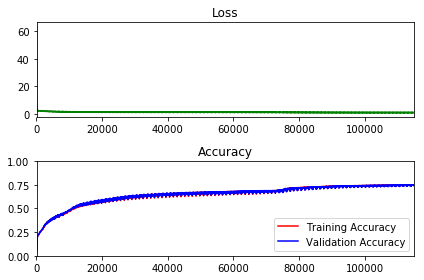

Validation accuracy at 0.7401333451271057


In [11]:
# Change if you have memory restrictions
batch_size = 128

epochs = 100
learning_rate = 0.01


### DON'T MODIFY ANYTHING BELOW ###
# Gradient Descent
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)    

# The accuracy measured against the validation set
validation_accuracy = 0.0

# Measurements use for graphing loss and accuracy
log_batch_step = 50
batches = []
loss_batch = []
train_acc_batch = []
valid_acc_batch = []

with tf.Session() as session:
    session.run(init)
    batch_count = int(math.ceil(len(train_features)/batch_size))

    for epoch_i in range(epochs):
        
        # Progress bar
        batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(epoch_i+1, epochs), unit='batches')
        
        # The training cycle
        for batch_i in batches_pbar:
            # Get a batch of training features and labels
            batch_start = batch_i*batch_size
            batch_features = train_features[batch_start:batch_start + batch_size]
            batch_labels = train_labels[batch_start:batch_start + batch_size]

            # Run optimizer and get loss
            _, l = session.run(
                [optimizer, loss],
                feed_dict={features: batch_features, labels: batch_labels})

            # Log every 50 batches
            if not batch_i % log_batch_step:
                # Calculate Training and Validation accuracy
                training_accuracy = session.run(accuracy, feed_dict=train_feed_dict)
                validation_accuracy = session.run(accuracy, feed_dict=valid_feed_dict)

                # Log batches
                previous_batch = batches[-1] if batches else 0
                batches.append(log_batch_step + previous_batch)
                loss_batch.append(l)
                train_acc_batch.append(training_accuracy)
                valid_acc_batch.append(validation_accuracy)

        # Check accuracy against Validation data
        validation_accuracy = session.run(accuracy, feed_dict=valid_feed_dict)
        if not epoch_i % 20:
            print("validation accuracy: ", validation_accuracy)

loss_plot = plt.subplot(211)
loss_plot.set_title('Loss')
loss_plot.plot(batches, loss_batch, 'g')
loss_plot.set_xlim([batches[0], batches[-1]])
acc_plot = plt.subplot(212)
acc_plot.set_title('Accuracy')
acc_plot.plot(batches, train_acc_batch, 'r', label='Training Accuracy')
acc_plot.plot(batches, valid_acc_batch, 'b', label='Validation Accuracy')
acc_plot.set_ylim([0, 1.0])
acc_plot.set_xlim([batches[0], batches[-1]])
acc_plot.legend(loc=4)
plt.tight_layout()
plt.show()

print('Validation accuracy at {}'.format(validation_accuracy))



## Test on the test set

In [12]:
# The accuracy measured against the test set
test_accuracy = 0.0

with tf.Session() as session:
    
    session.run(init)
    batch_count = int(math.ceil(len(train_features)/batch_size))

    for epoch_i in range(epochs):
        
        # Progress bar
        batches_pbar = tqdm(range(batch_count), desc='Epoch {:>2}/{}'.format(epoch_i+1, epochs), unit='batches')
        
        # The training cycle
        for batch_i in batches_pbar:
            # Get a batch of training features and labels
            batch_start = batch_i*batch_size
            batch_features = train_features[batch_start:batch_start + batch_size]
            batch_labels = train_labels[batch_start:batch_start + batch_size]

            # Run optimizer
            _ = session.run(optimizer, feed_dict={features: batch_features, labels: batch_labels})

        # Check accuracy against Test data
        test_accuracy = session.run(accuracy, feed_dict=test_feed_dict)

print('Test Accuracy is {}'.format(test_accuracy))

Epoch 100/100: 100%|██████████| 1114/1114 [00:00<00:00, 1303.39batches/s]

Test Accuracy is 0.8195000290870667
